In [94]:
import sys

sys.path.append('../')
import pandas as pd
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from src.ewenpyomo import ewen_model
from src.neural_network import create_nn, data_scaling
from src.omlt_model import create_model

__OMLT__

In [134]:
# Data loading
df = pd.read_csv('../data/datasetcost.csv')
df = df.sample(5000, random_state=42)

inputs = list(df.columns)
inputs.remove('total_cost')
outputs = ['total_cost']

print(f'Dataset shape: {df.shape}')

Dataset shape: (5000, 7)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 1/200
53/53 - 1s - loss: 1.0656 - val_loss: 0.8855 - 1s/epoch - 23ms/step
Epoch 2/200
53/53 - 0s - loss: 1.0376 - val_loss: 0.8472 - 163ms/epoch - 3ms/step
Epoch 3/200
53/53 - 0s - loss: 1.0039 - val_loss: 0.8107 - 169ms/epoch - 3ms/step
Epoch 4/200
53/53 - 0s - loss: 0.9228 - val_loss: 0.7022 - 147ms/epoch - 3ms/step
Epoch 5/200
53/53 - 0s - loss: 0.7774 - val_loss: 0.5556 - 145ms/epoch - 3ms/step
Epoch 6/200
53/53 - 0s - loss: 0.6094 - val_loss: 0.4480 - 145ms/epoch - 3ms/step
Epoch 7/200
53/53 - 0s - loss: 0.5223 - val_loss: 0.4198 - 154ms/epoch - 3ms/step
Epoch 8/200
53/53 - 0s - loss: 0.4873 - val_loss: 0.4041 - 145ms/epoch - 3ms/step
Epoch 9/200
53/53 - 0s - loss: 0.4650 - val_loss: 0.3858 - 163ms/epoch - 3ms/step
Epoch 10/200
53/53 - 0s - loss: 0.4400 - val_loss: 0.3559 - 154ms/epoch - 3ms/step
Epoch 11/200
53/53 - 0s - loss: 0.4115 - val_loss: 0.3363 - 159ms/epoch - 3ms/step
Epoch 12/2

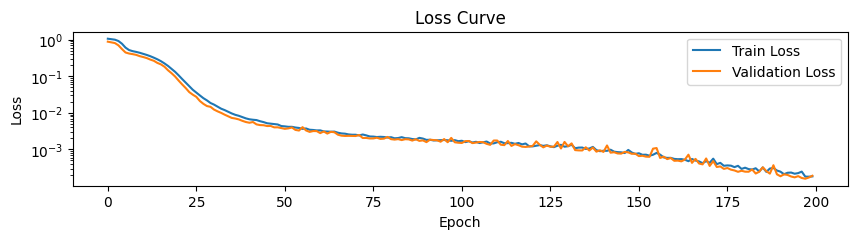

In [135]:
%load_ext autoreload
%autoreload

# Data scaling
x, y, x_offset, x_factor, \
    y_offset, y_factor, scaled_lb, scaled_ub = data_scaling(df, inputs, outputs)
    
# Create and train a ANN
net = create_nn(x, y)

In [136]:
import tensorflow.keras as keras
from omlt import OffsetScaling, OmltBlock
from omlt.io.keras import load_keras_sequential
from omlt.neuralnet import (
    FullSpaceNNFormulation,
    FullSpaceSmoothNNFormulation,
    NetworkDefinition,
    ReducedSpaceSmoothNNFormulation,
    ReluBigMFormulation,
    ReluComplementarityFormulation,
    ReluPartitionFormulation,
)

omlt_model = pyo.ConcreteModel()
omlt_model.cost = OmltBlock()
nn_cost = keras.models.load_model('cost_nn.keras', compile=False)

scaler = OffsetScaling(
    offset_inputs={i: x_offset[inputs[i]] for i in range(len(inputs))},
    factor_inputs={i: x_factor[inputs[i]] for i in range(len(inputs))},
    offset_outputs={i: y_offset[outputs[i]] for i in range(len(outputs))},
    factor_outputs={i: y_factor[outputs[i]] for i in range(len(outputs))},
)

scaled_input_bounds = {i: (scaled_lb[i], scaled_ub[i]) for i in range(len(inputs))}

net = load_keras_sequential(
    nn_cost, scaling_object=scaler, scaled_input_bounds=scaled_input_bounds
)
omlt_model.cost.build_formulation(FullSpaceSmoothNNFormulation(net))


In [137]:
# Load ewen basic model
ewen_pyomo_model = ewen_model()

# Create merged model
model = pyo.ConcreteModel()
model.model1 = ewen_pyomo_model
model.model2 = omlt_model

In [138]:
cost = outputs.index('total_cost')

# Create objective function
model.obj = pyo.Objective(expr=model.model1.EFTotal + model.model2.cost.outputs[cost], sense=pyo.minimize)
# model.obj = pyo.Objective(expr=model.model1.EFTotal, sense=pyo.minimize)

In [139]:
FiR_1 = inputs.index('Fir1')
FiR_2 = inputs.index('Fir2')
FiR_3 = inputs.index('Fir3')
CiR_1 = inputs.index('Cir1')
CiR_2 = inputs.index('Cir2')
CiR_3 = inputs.index('Cir3')

model.constraint1 = pyo.Constraint(expr=model.model1.FiR[1] == model.model2.cost.inputs[FiR_1])
model.constraint2 = pyo.Constraint(expr=model.model1.FiR[2] == model.model2.cost.inputs[FiR_2])
model.constraint3 = pyo.Constraint(expr=model.model1.FiR[3] == model.model2.cost.inputs[FiR_3])

model.constraint4 = pyo.Constraint(expr=model.model1.CiR[1] == model.model2.cost.inputs[CiR_1])
model.constraint5 = pyo.Constraint(expr=model.model1.CiR[2] == model.model2.cost.inputs[CiR_2])
model.constraint6 = pyo.Constraint(expr=model.model1.CiR[3] == model.model2.cost.inputs[CiR_3])

In [140]:
solver = pyo.SolverFactory('ipopt')
results = solver.solve(model, tee=False)

In [141]:
print(f'EFTotal value: {model.obj()}')
print(f'cost value: {model.model2.cost.outputs[cost].value}')
print(f'ERTotal value: {model.model1.ERTotal()}')
print(f'interc value: {model.model1.interc()}')

print(f'FiR_1 = {model.model1.FiR[1].value}')
print(f'FiR_2 = {model.model1.FiR[2].value}')
print(f'FiR_3 = {model.model1.FiR[3].value}')

print(f'CiR_1 = {model.model1.CiR[1].value}')
print(f'CiR_2 = {model.model1.CiR[2].value}')
print(f'CiR_3 = {model.model1.CiR[3].value}')

EFTotal value: 171.74611265237462
cost value: 47.30953071839444
ERTotal value: 207.3134151743862
interc value: 28.0
FiR_1 = 53.608958473829624
FiR_2 = 24.64145985805136
FiR_3 = 129.0629968425052
CiR_1 = 8041.343669087907
CiR_2 = 3696.2184608473312
CiR_3 = 29989.062759908335
